<a href="https://colab.research.google.com/github/SandeepJosyula/NeuralNetworks/blob/Computer-Vision/SJ_ComputerVision_Project2_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 - Advanced Computer Vision
## Face Recognition
In this hands-on project, the goal is to build a face identification model to recognize faces.

**Dataset**

Aligned Face Dataset from Pinterest
This dataset contains 10,770 images for 100 people. All images are taken from
'Pinterest' and aligned using dlib library.

**Overview**

In this problem, we use a pre-trained model trained on Face recognition to recognize similar faces.Here, we are particularly interested in recognizing whether two given faces are of the same person or not. Below are the steps involved in the project.

 - Load the dataset and create the metadata.
 - Check some samples of metadata.
 - Load the pre-trained model and weights.
 - Generate Embedding vectors for each face in the dataset.
 - Build distance metrics for identifying the distance between two given images.
 - Use PCA for dimensionality reduction.
 - Build an SVM classifier to map each image to its right person.
 - Predict using the SVM model.


# Face recognition
Task is to recognize a faces

## Load Libraries

In [1]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [2]:
import os
import numpy as np
import cv2
from zipfile import ZipFile
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Change current working directory to project folder (2 marks)**

In [4]:
os.chdir('/content/drive/My Drive/Study/AI_ML_Study/GreatLearning_UT_Texas/9.Computer_Vision/Project2')
project_path = '/content/drive/My Drive/Study/AI_ML_Study/GreatLearning_UT_Texas/9.Computer_Vision/Project2/'

## Load the datasaet
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.

### Extract the zip file (3 marks)
- Extract Aligned Face Dataset from Pinterest.zip

In [5]:
# Requires to be executed only once to extract the zip file
# commented out since the zip file has already been extracted in my google drive

#with ZipFile(project_path+'Aligned Face Dataset from Pinterest.zip', 'r') as z:
#  z.extractall()     

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [6]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

In [7]:
print(metadata.shape)

(11054,)


### Define function to load image
- Define a function to load image from the metadata

In [8]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

### Load a sample image (3 marks)
- Load one image using the function "load_image"

/content/drive/My Drive/Study/AI_ML_Study/GreatLearning_UT_Texas/9.Computer_Vision/Project2/PINS/pins_Thomas Middleditch/Thomas Middleditch50.jpg


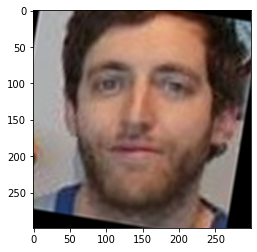

In [9]:
print(project_path + metadata[10].image_path())
plt.imshow(load_image(project_path + metadata[10].image_path()))

/content/drive/My Drive/Study/AI_ML_Study/GreatLearning_UT_Texas/9.Computer_Vision/Project2/PINS/pins_Tom Cavanagh/Tom Cavanagh22.jpg


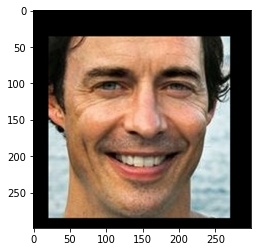

In [10]:
print(project_path + metadata[110].image_path())
plt.imshow(load_image(project_path + metadata[110].image_path()))

## VGG Face model
- Here we are giving you the predefined model for VGG face

In [11]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

### Load the model (3 marks)
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [12]:
WEIGHTS_FILE = project_path + "vgg_face_weights.h5"
THRESHOLD = 0.8
EPSILON = 0.02

# Create the model
model = vgg_face()

# Load the pre-trained weights
model.load_weights(WEIGHTS_FILE)

# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

## Get vgg_face_descriptor

In [13]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

## Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [14]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images (8 marks)
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [ ]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
  # Load image
  img = load_image(metadata[i].image_path())

  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (img / 255.).astype(np.float32)
  # Resize the image to a fixed size of 224 x 224
  img = cv2.resize(img, dsize = (224,224))
  
  # Get the embedding vector for the image using vgg_face_descriptor model  
  embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
  
# Since the time taken for all the images is very high, restricted the distance calculation activity to first 150 images only
#  if i == 150:
#    break

print(embeddings.shape)


In [ ]:
from numpy import savetxt
savetxt('embeddings.npy', embeddings)

In [ ]:
# load numpy array from csv file
from numpy import load
# load array
data = load('embeddings.npy', allow_pickle=True)

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

In [ ]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    
    print('First Image: ',project_path + metadata[idx1].image_path())
    print('Second Image: ',project_path + metadata[idx2].image_path())

show_pair(2, 3)
show_pair(2, 180)
show_pair(30, 31)
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)


## Create train and test sets (8 marks)
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]

# Create the targets array
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
print(y_train.shape)
print(y_test.shape)

### Encode the Labels (4 marks)
- Encode the targets
- Use LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
# create an instance of LabelEncoder class
Le = LabelEncoder()

# Fit the labels for train set which is with us
Le.fit(y_train)

# Transform the labels for train and test set
y_train_encoded = Le.transform(y_train)

# Reason why the fit is performed on train, but applied to test is because we may not know if a new image would be tested
# in current dataset, there is no possibility of test data set having an entirely new image since we sampled every 9th image
y_test_encoded = Le.transform(y_test)

### Standardize the feature values (4 marks)
- Scale the features using StandardScaler

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler

# Create a class instace for scaler
scaler = StandardScaler()

# Fit the scaler on the train dataset
scaler.fit(X_train)
scaler.transform(X_train)

# Fit the scaler on the test dataset
scaler.fit(X_test)
scaler.transform(X_test)

## Reduce dimensions using PCA (4 marks)
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [ ]:
from sklearn.decomposition import PCA

# instantiate the pca class
pca = PCA(n_components=100)

# Fit the PCA with train dataset and transform
X_train_pca = pca.fit_transform(X_train)

# Fit the PCA with test dataset and transform
X_test_pca = pca.fit_transform(X_test)

## Build a Classifier (4 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# instantiate the classifier
svc = SVC(gamma='auto')

svc.fit(X_train_pca, y_train_encoded)

In [ ]:
y_train_pred = svc.predict(X_train_pca)
print(confusion_matrix(y_train_encoded,y_train_pred))
#print(classification_report(y_train_encoded,y_train_pred))

In [ ]:
y_test_pred = svc.predict(X_test_pca)
print(confusion_matrix(y_test_encoded,y_test_pred))
#print(classification_report(y_test_encoded,y_test_pred))

## Test results (2 mark)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

In [ ]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

# pick the 10th image in test set
example_idx = 10

example_image = load_image(project_path + metadata[test_idx][example_idx].image_path())

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
example_image = (example_image / 255.).astype(np.float32)
# Resize the image to 224 x 224
example_image = cv2.resize(example_image, dsize = (224,224))
# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(example_image, axis=0))
# Fit the scaler on the test dataset
scaler.fit(X_test)
scaler.fit_transform(embedding_vector)
# Perform PCA on the embedding vector
pca.fit(X_test)
embedding_vector_pca = pca.transform(embedding_vector)

In [ ]:
example_prediction = svc.predict(embedding_vector_pca) 
example_identity = Le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');